In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
dataset_dict = load_dataset("wachawich/REG-Forecasting_v2")
dataset = dataset_dict["train"]
df = dataset.to_pandas()
print(df.head())
print(df.columns)
df.value


c:\Users\Xenosz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   time        date  day  month  year  fueltype type-name  solar_count  \
0     0  2020-01-01    1      1  2020         1     Solar        34.95   
1     0  2020-01-01    1      1  2020         2      Wind        34.95   
2     1  2020-01-01    1      1  2020         1     Solar        34.95   
3     1  2020-01-01    1      1  2020         2      Wind        34.95   
4     2  2020-01-01    1      1  2020         1     Solar        34.95   

   wind_turbine_count  value  ...  sunrise_time_h  sunrise_time_m  \
0                2400   1403  ...               7              10   
1                2400    225  ...               7              10   
2                2400    -35  ...               7              10   
3                2400    222  ...               7              10   
4                2400    -30  ...               7              10   

   sunset_time_h  sunset_time_m  sin_time  cos_time  day_of_month_sin  \
0             16             51  0.000000  1.000000          0.2012

0          1403
1           225
2           -35
3           222
4           -30
          ...  
103120     1398
103121    10192
103122     1158
103123    10026
103124      979
Name: value, Length: 103125, dtype: int64

In [2]:
df_solar = df[df["fueltype"] == 1].reset_index(drop=True)
df_wind  = df[df["fueltype"] == 2].reset_index(drop=True)


In [3]:
feature_cols_candidate = [
    'day',
    'month',
    'day_of_year',
    'sin_doy',
    'cos_doy',
    'sin_time',
    'cos_time',
    'season',
    'shortwave_radiation',
    'direct_radiation',
    'diffuse_radiation',
    'direct_normal_irradiance',
    'cloudcover',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_high',
    'temperature_2m',
    'relativehumidity_2m',
    'dewpoint_2m',
    'surface_pressure',
    'vapour_pressure_deficit',
    'precipitation',
    'rain',
    'snowfall',
    'solar_zenith_noon_deg',
    'sunrise_time_h',
    'sunrise_time_m',
    'sunset_time_h',
    'sunset_time_m',
    'solar_count',
]

feature_cols = [c for c in feature_cols_candidate if c in df.columns]

target_col = "value"   


Model

In [4]:
def create_sequences(X, y, window=48):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)


In [5]:
def prepare_dataset(df_part, feature_cols, target_col, window=48, batch=64):
    
    X_raw = df_part[feature_cols].astype(float).values
    y_raw = df_part[target_col].astype(float).values.reshape(-1, 1)
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_scaled = x_scaler.fit_transform(X_raw)
    y_scaled = y_scaler.fit_transform(y_raw)
    
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window)
    
    split = int(len(X_seq) * 0.99)
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_test,  y_test  = X_seq[split:], y_seq[split:]
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch, shuffle=False)
    
    return {
        "X_train_t": X_train_t,
        "y_train_t": y_train_t,
        "X_test_t":  X_test_t,
        "y_test_t":  y_test_t,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
    }


In [6]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


In [7]:
def train_gru(model, train_loader, epochs=40, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} - Loss: {total_loss:.6f}")


Solar

In [8]:
df_solar = df_solar[df_solar['shortwave_radiation'] > 10].copy()
df_solar = df_solar.reset_index(drop=True)

In [9]:
df_solar["value_lag_1"] = df_solar["value"].shift(1)
df_solar["value_lag_2"] = df_solar["value"].shift(2)
df_solar["value_lag_3"] = df_solar["value"].shift(3)
df_solar["value_lag_24"] = df_solar["value"].shift(24)
df_solar["value_lag_48"] = df_solar["value"].shift(48)

df_solar["value_roll_24"] = df_solar["value"].rolling(24).mean()
df_solar["value_roll_48"] = df_solar["value"].rolling(48).mean()
df_solar["value_std_24"]  = df_solar["value"].rolling(24).std()

df_solar = df_solar.dropna().reset_index(drop=True)
base_features = feature_cols
solar_feature_cols =  base_features +[
    "value_lag_1","value_lag_2","value_lag_3","value_lag_24", "value_lag_48",
    "value_roll_24", "value_roll_48", "value_std_24"
]


In [10]:

steps_per_hour = 1

df_solar['cloud_volatility_1h'] = df_solar['cloudcover'].rolling(window=steps_per_hour).std()

df_solar['cloud_diff'] = df_solar['cloudcover'].diff()

df_solar['cloud_volatility_1h'] = df_solar['cloud_volatility_1h'].fillna(0)
df_solar['cloud_diff'] = df_solar['cloud_diff'].fillna(0)

print(df_solar[['cloudcover', 'cloud_volatility_1h', 'cloud_diff']].head(10))

   cloudcover  cloud_volatility_1h  cloud_diff
0          19                  0.0         0.0
1          31                  0.0        12.0
2          10                  0.0       -21.0
3           8                  0.0        -2.0
4           6                  0.0        -2.0
5           2                  0.0        -4.0
6           1                  0.0        -1.0
7           1                  0.0         0.0
8           0                  0.0        -1.0
9           0                  0.0         0.0


In [11]:
solar_data = prepare_dataset(
    df_part=df_solar,
    feature_cols=solar_feature_cols,
    target_col=target_col,
    window=48,
    batch=64
)

solar_model = GRUModel(input_size=len(solar_feature_cols))
print("Solar input_size:", len(solar_feature_cols))
print("\n=== Training Solar GRU ===")
train_gru(solar_model, solar_data["train_loader"], epochs=60)


Solar input_size: 38

=== Training Solar GRU ===
Epoch 1/60 - Loss: 5.816076
Epoch 2/60 - Loss: 1.640245
Epoch 3/60 - Loss: 1.213850
Epoch 4/60 - Loss: 1.140314
Epoch 5/60 - Loss: 1.080722
Epoch 6/60 - Loss: 1.025506
Epoch 7/60 - Loss: 0.989151
Epoch 8/60 - Loss: 0.933578
Epoch 9/60 - Loss: 0.974707
Epoch 10/60 - Loss: 0.959988
Epoch 11/60 - Loss: 0.883655
Epoch 12/60 - Loss: 0.906311
Epoch 13/60 - Loss: 0.854340
Epoch 14/60 - Loss: 0.850458
Epoch 15/60 - Loss: 0.862744
Epoch 16/60 - Loss: 0.762743
Epoch 17/60 - Loss: 0.758317
Epoch 18/60 - Loss: 0.742562
Epoch 19/60 - Loss: 0.801025
Epoch 20/60 - Loss: 0.690609
Epoch 21/60 - Loss: 0.726114
Epoch 22/60 - Loss: 0.700614
Epoch 23/60 - Loss: 0.701453
Epoch 24/60 - Loss: 0.693547
Epoch 25/60 - Loss: 0.706816
Epoch 26/60 - Loss: 0.660049
Epoch 27/60 - Loss: 0.653369
Epoch 28/60 - Loss: 0.600503
Epoch 29/60 - Loss: 0.602228
Epoch 30/60 - Loss: 0.638270
Epoch 31/60 - Loss: 0.590687
Epoch 32/60 - Loss: 0.599775
Epoch 33/60 - Loss: 0.589956
Epo

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_test_t = solar_data["X_test_t"]
y_test_t = solar_data["y_test_t"]
y_scaler = solar_data["y_scaler"]

solar_model.eval()
with torch.no_grad():
    preds_test_scaled = solar_model(X_test_t.to(device)).cpu().numpy()

y_test_scaled = y_test_t.numpy()

y_test_real     = y_scaler.inverse_transform(y_test_scaled)
preds_test_real = y_scaler.inverse_transform(preds_test_scaled)

rmse_real = np.sqrt(mean_squared_error(y_test_real, preds_test_real))
print("Solar RMSE (real scale):", rmse_real)


Solar RMSE (real scale): 459.9771054085192


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

solar_model.to(device)
solar_model.eval()

scaler = solar_data['y_scaler'] 

preds_train_list = []

print(f"Start predicting on device: {device}")

with torch.no_grad():
    for X_batch, y_batch in solar_data["train_loader"]:
        X_batch = X_batch.to(device) 
        y_pred = solar_model(X_batch)
        preds_train_list.append(y_pred.cpu().numpy())

if len(preds_train_list) > 0:
    preds_train_scaled = np.concatenate(preds_train_list, axis=0)
    preds_train_real = scaler.inverse_transform(preds_train_scaled).flatten()
    
    print("Success!")
    print("Shape preds_train_real:", preds_train_real.shape)
else:
    print("Error: Prediction")

Start predicting on device: cuda
Success!
Shape preds_train_real: (25544,)


In [14]:
preds_test_list = []

print("Start predicting Test set...")
with torch.no_grad():
    for X_batch, y_batch in solar_data["test_loader"]:
        X_batch = X_batch.to(device) 
        y_pred = solar_model(X_batch)
        preds_test_list.append(y_pred.cpu().numpy())

if len(preds_test_list) > 0:
    preds_test_scaled = np.concatenate(preds_test_list, axis=0)
    preds_test_real = scaler.inverse_transform(preds_test_scaled).flatten()
    print("Test Prediction Shape:", preds_test_real.shape)

Start predicting Test set...
Test Prediction Shape: (259,)


In [15]:
train_loader_plot = DataLoader(
    TensorDataset(solar_data['X_train_t'], solar_data['y_train_t']), 
    batch_size=64, 
    shuffle=False 
)

preds_train_list = []
solar_model.eval() 

print("Predicting Train set (Ordered for Plotting)...")
with torch.no_grad():
    for X_batch, y_batch in train_loader_plot: 
        X_batch = X_batch.to(device)
        y_pred = solar_model(X_batch)
        preds_train_list.append(y_pred.cpu().numpy())

scaler = solar_data['y_scaler']
preds_train_scaled = np.concatenate(preds_train_list, axis=0)
preds_train_real = scaler.inverse_transform(preds_train_scaled).flatten()


Predicting Train set (Ordered for Plotting)...


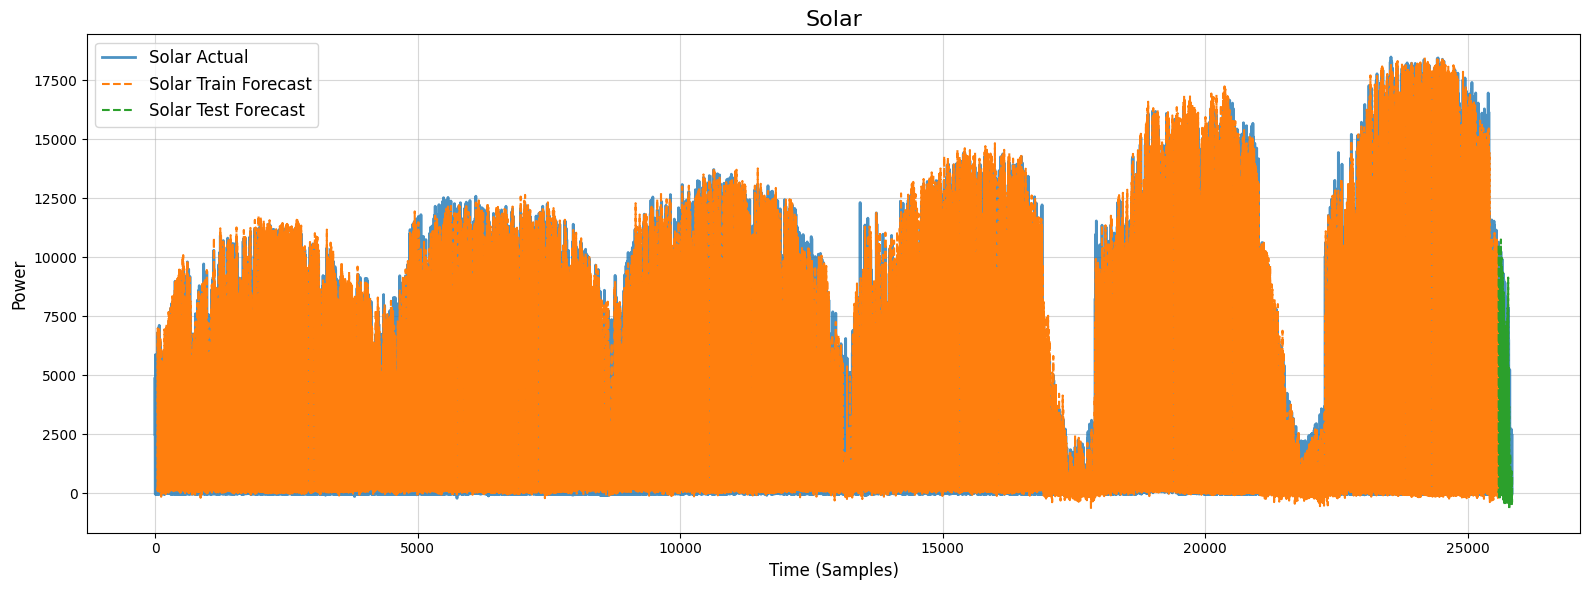

In [16]:
look_back = 48  
train_len = len(preds_train_real)
test_len  = len(preds_test_real)

train_range = np.arange(look_back, look_back + train_len)

test_range = np.arange(look_back + train_len, look_back + train_len + test_len)

plt.figure(figsize=(16, 6)) 

plt.plot(df_solar[target_col].values, label='Solar Actual', color='#1f77b4', linewidth=2, alpha=0.8)

plt.plot(train_range, preds_train_real, 
        label='Solar Train Forecast', linestyle='--', color='#ff7f0e', linewidth=1.5)

plt.plot(test_range, preds_test_real, 
        label='Solar Test Forecast', linestyle='--', color='#2ca02c', linewidth=1.5)

plt.title('Solar', fontsize=16)
plt.xlabel('Time (Samples)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(loc='upper left', fontsize=12) 
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()


=== Overall Performance (Total Steps: 25803) ===
Accuracy OverAll: 98.46%
Accuracy Train:      98.46%
Accuracy Test:       98.71%


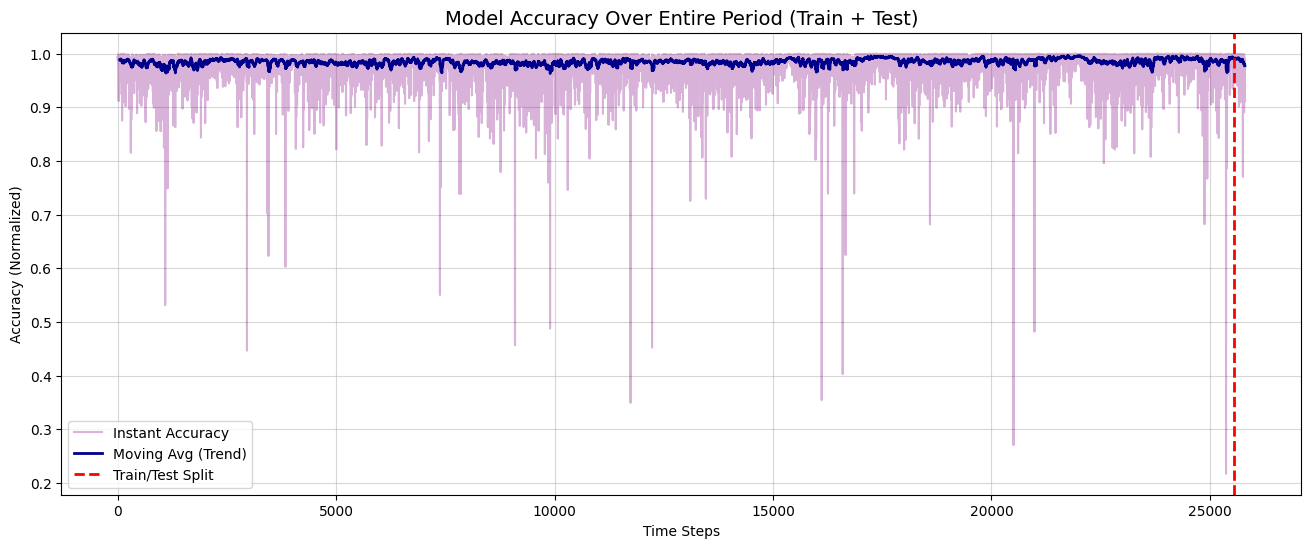

In [17]:
all_preds = np.concatenate([preds_train_real, preds_test_real])

look_back = 48
total_len = len(all_preds)
all_actual = df_solar[target_col].values[look_back : look_back + total_len]

max_capacity = all_actual.max()
abs_err = np.abs(all_preds - all_actual)

acc_per_point = 1.0 - (abs_err / max_capacity)
acc_per_point = np.clip(acc_per_point, 0, 1) 

print(f"=== Overall Performance (Total Steps: {total_len}) ===")
print(f"Accuracy OverAll: {acc_per_point.mean() * 100:.2f}%")
print(f"Accuracy Train:      {acc_per_point[:len(preds_train_real)].mean() * 100:.2f}%")
print(f"Accuracy Test:       {acc_per_point[len(preds_train_real):].mean() * 100:.2f}%")

plt.figure(figsize=(16, 6))

time_steps = np.arange(total_len)

plt.plot(time_steps, acc_per_point, color='purple', alpha=0.3, label='Instant Accuracy')

rolling_acc = pd.Series(acc_per_point).rolling(window=48).mean() 
plt.plot(time_steps, rolling_acc, color='darkblue', linewidth=2, label='Moving Avg (Trend)')

split_point = len(preds_train_real)
plt.axvline(x=split_point, color='red', linestyle='--', linewidth=2, label='Train/Test Split')

plt.title('Model Accuracy Over Entire Period (Train + Test)', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Accuracy (Normalized)')
plt.legend()
plt.grid(True, alpha=0.5)

plt.show()